Epoch 0, Loss: 15.087740898132324
Epoch 100, Loss: 12.538195610046387
Epoch 200, Loss: 8.068503379821777
Epoch 300, Loss: 0.8247799277305603
Epoch 400, Loss: 0.3842410445213318
Epoch 500, Loss: 0.403459757566452
Epoch 600, Loss: 0.36948516964912415
Epoch 700, Loss: 0.3648293912410736
Epoch 800, Loss: 0.36475515365600586
Epoch 900, Loss: 0.3620063066482544
Epoch 1000, Loss: 0.38420721888542175
Epoch 1100, Loss: 0.4196702539920807
Epoch 1200, Loss: 0.42304912209510803
Epoch 1300, Loss: 0.3725842833518982
Epoch 1400, Loss: 0.3512980043888092
Epoch 1500, Loss: 0.35630401968955994
Epoch 1600, Loss: 0.34637168049812317
Epoch 1700, Loss: 0.3665202558040619
Epoch 1800, Loss: 0.3433414697647095
Epoch 1900, Loss: 0.3616999089717865
Epoch 2000, Loss: 0.334703654050827
Epoch 2100, Loss: 0.33567923307418823
Epoch 2200, Loss: 0.33459240198135376
Epoch 2300, Loss: 0.3312631845474243
Epoch 2400, Loss: 0.3368498980998993
Epoch 2500, Loss: 0.3473888337612152
Epoch 2600, Loss: 0.32559311389923096
Epoch 2

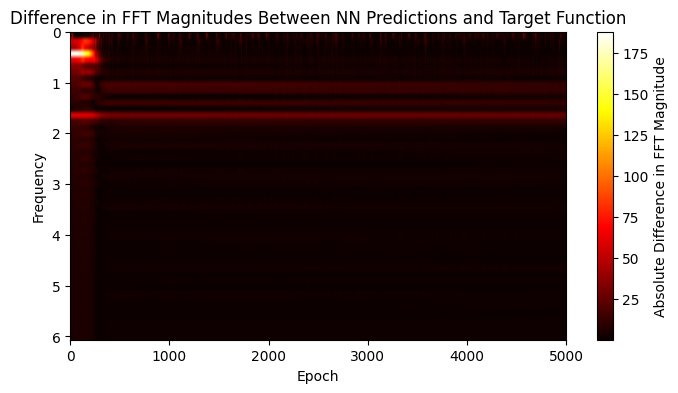

In [47]:
import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

L = 4
target_func = lambda x: 0.5 * x + 5 * jnp.sin(2 * x) + 1 * jnp.sin(10 * x)

def generate_data(n_samples=100):
    x = np.linspace(-L, L, n_samples)
    noise = np.random.normal(0, 0.1, x.shape)
    y = target_func(x) + noise
    return x, y

class MLP(nn.Module):
    hidden_size: int = 256
    
    @nn.compact
    def __call__(self, x):
        x = nn.relu(nn.Dense(self.hidden_size)(x))
        x = nn.relu(nn.Dense(self.hidden_size)(x))
        return nn.Dense(1)(x)

# Generate data
x_train, y_train = generate_data(100)
x_train = jnp.array(x_train).reshape(-1, 1)
y_train = jnp.array(y_train).reshape(-1, 1)

# Generate test data
x_test = jnp.linspace(-L, L, 100).reshape(-1, 1)

# Initialize and train model
model = MLP()
rng = jax.random.PRNGKey(0)
params = model.init(rng, jnp.ones((1, 1)))['params']
optim = optax.adam(1e-3)
opt_state = optim.init(params)

@jax.jit
def train_step(params, opt_state, x, y):
    def loss_fn(params):
        pred = model.apply({'params': params}, x)
        return jnp.mean((pred - y) ** 2)
    
    loss, grads = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = optim.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

# Function to compute FFT
def compute_fft(y, x):
    n = len(x)
    fft_values = np.fft.fft(y.flatten())
    freqs = np.fft.fftfreq(n, d=(x[1] - x[0]))
    return freqs, np.abs(fft_values)

# Compute FFT of the target function
freqs_gt, fft_gt = compute_fft(target_func(x_test), x_test)

# Store FFT magnitudes over epochs
epochs = 5000
fft_differences = []
epoch_indices = []

# Train the model and compute FFT at each epoch
for epoch in range(epochs):
    params, opt_state, loss = train_step(params, opt_state, x_train, y_train)
    
    # Compute FFT of predictions every 10 epochs
    if epoch % 10 == 0:
        y_pred_test = model.apply({'params': params}, x_test)
        freqs_pred, fft_pred = compute_fft(y_pred_test, x_test)
        
        # Compute the absolute difference between the FFT of predictions and the target function
        fft_diff = np.abs(fft_pred - fft_gt)
        fft_differences.append(fft_diff)
        epoch_indices.append(epoch)
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss}")

# Convert FFT differences to a numpy array
fft_differences = np.array(fft_differences)

# Keep only non-negative frequencies (FFT is symmetric for real-valued signals)
positive_freq_mask = freqs_gt >= 0
freqs_gt = freqs_gt[positive_freq_mask]
fft_differences = fft_differences[:, positive_freq_mask]

# Create a heatmap of FFT differences over epochs
plt.figure(figsize=(8, 4))

# Plot the heatmap
plt.imshow(fft_differences.T, aspect='auto', cmap='hot',
           extent=[0, epochs, freqs_gt.max(), freqs_gt.min()])
plt.colorbar(label="Absolute Difference in FFT Magnitude")
plt.xlabel("Epoch")
plt.ylabel("Frequency")
plt.title("Difference in FFT Magnitudes Between NN Predictions and Target Function")
plt.show()

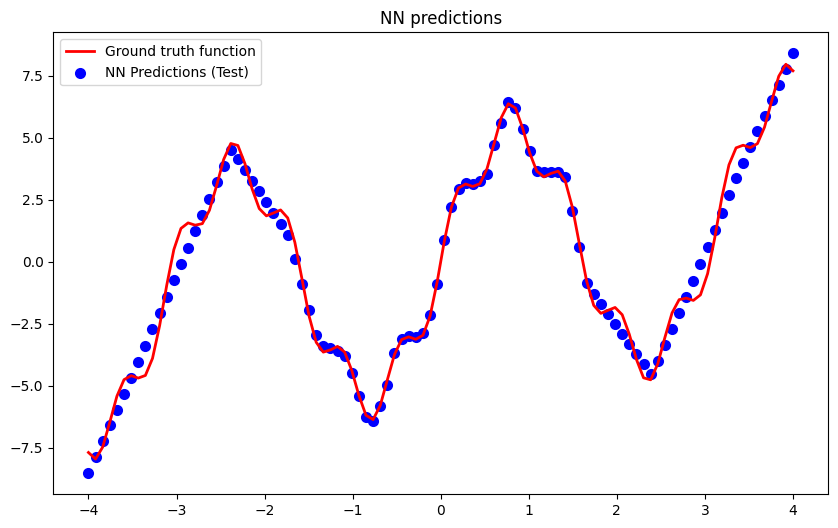

In [30]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x_train, target_func(x_train), color='red', linewidth=2, label="Ground truth function")
plt.scatter(x_test, y_pred_test, color='blue', linewidth=2, label="NN Predictions (Test)")
plt.title("NN predictions")
plt.legend()
plt.show()

In [31]:
from jax.flatten_util import ravel_pytree

def u(params, x):
    x = jnp.array([x])
    y = model.apply({'params': params}, x)
    return y

grad_f = jax.jit(jax.jacrev(u, (0))) # (params, jnp.array([3.]))

def ntk_ij(x_i, x_j, params, grad_f):
    return ravel_pytree(grad_f(params, x_i))[0] @ ravel_pytree(grad_f(params, x_j))[0]

In [32]:
x_i = jnp.array([3.])
x_j = jnp.array([2.])
ntk_ij(x_i, x_j, params, grad_f)

Array(3756.8237, dtype=float32)

In [39]:
def kernel_regression_ntk(params):
    X_I, X_J = jnp.meshgrid(x_train.reshape(-1), x_train.reshape(-1))
    K_train_train = jax.vmap(jax.vmap(ntk_ij, (0,0,None,None)), (0,0,None,None))(X_I, X_J, params,grad_f)
    
    X_I, X_J = jnp.meshgrid(x_test.reshape(-1), x_train.reshape(-1))
    K_test_train = jax.vmap(jax.vmap(ntk_ij, (0,0,None,None)), (0,0,None,None))(X_I, X_J, params,grad_f)
    
    regularization = 1e-3
    # Add regularization and invert K_train_train
    K_reg = K_train_train + regularization * jnp.eye(K_train_train.shape[0])
    K_inv = jnp.linalg.inv(K_reg)
    
    # Compute predictions
    kernel_preds = K_test_train @ K_inv @ y_train
    return kernel_preds, K_train_train

kernel_preds, K_train_train = kernel_regression_ntk(params)

In [40]:
untrained_params = model.init(rng, jnp.ones((1, 1)))['params']
untrained_preds, _ = kernel_regression_ntk(untrained_params)

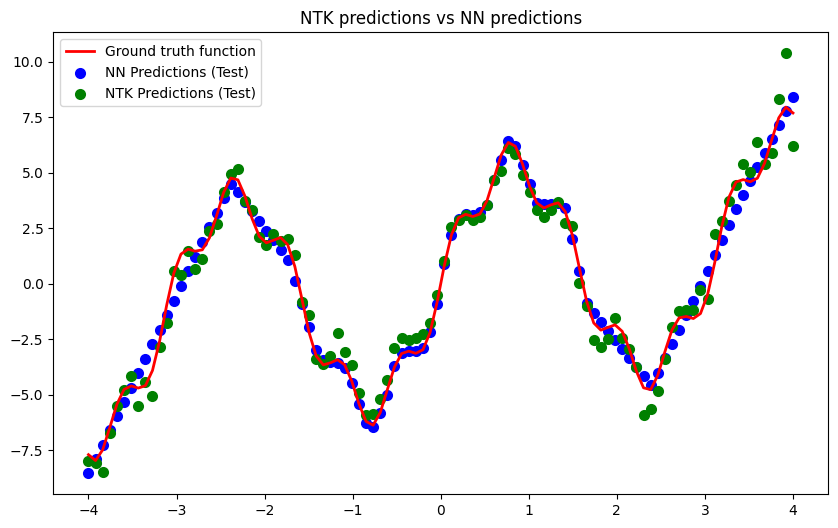

In [41]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x_train, target_func(x_train), color='red', linewidth=2, label="Ground truth function")
plt.scatter(x_test, y_pred_test, color='blue', linewidth=2, label="NN Predictions (Test)")
plt.scatter(x_test, kernel_preds, color='green', linewidth=2, label="NTK Predictions (Test)")
# plt.scatter(x_test, untrained_preds, color='yellow', linewidth=2, label="Untrained Kernel Predictions (Test)")
plt.title("NTK predictions vs NN predictions")
plt.legend()
plt.show()

In [42]:
y_test = jnp.sin(x_test)
jnp.mean((y_test - kernel_preds)**2), jnp.mean((y_test - y_pred_test)**2)

(Array(17.521431, dtype=float32), Array(16.534964, dtype=float32))

In [43]:
(evals, evecs) = jnp.linalg.eig(K_train_train)

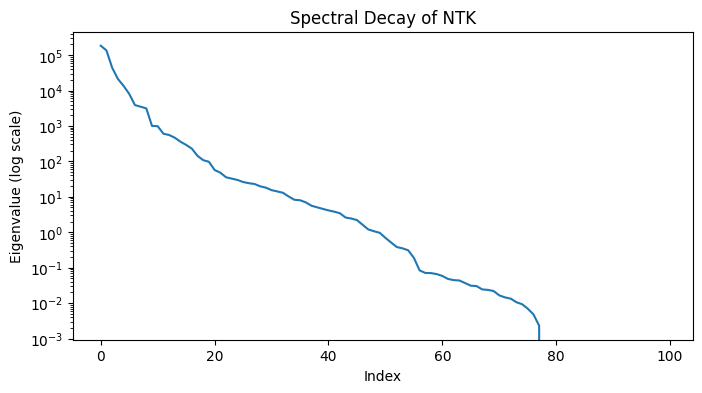

In [44]:
plt.figure(figsize=(8, 4))
plt.semilogy(jnp.sort(evals)[::-1])
plt.xlabel("Index")
plt.ylabel("Eigenvalue (log scale)")
plt.title("Spectral Decay of NTK")
plt.show()